In [1]:
%matplotlib inline

In [2]:
# python libraries
import menpo
import tensorflow as tf
import menpo.io as mio
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.python.platform import tf_logging as logging
from menpo.image import Image
from menpo.shape import PointCloud

# local libraries
import utils, networks, data_provider
import numpy as np 
import menpo.io as mio 
import scipy.io as sio
from io import BytesIO
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xml.etree.ElementTree as ET
import json
import glob
import cv2
import scipy
import utils
import os
from menpo.image import Image
from menpo.visualize import print_dynamic, print_progress
from scipy.spatial.distance import pdist
from pathlib import Path

from menpo.shape import PointCloud, PointUndirectedGraph
from menpo.transform import Translation
from menpofit.transform import DifferentiableAlignmentSimilarity

from menpowidgets import visualize_images, visualize_pointclouds
from IPython.html.widgets import interact
from IPython.html.widgets import Button
from IPython.display import display, clear_output

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import tensorflow as tf
slim = tf.contrib.slim

%matplotlib inline

np.set_printoptions(3)
slim = tf.contrib.slim

/vol/atlas/homes/yz4009/gitdev/menpofit/menpofit/math/fft_utils.py:20: RuntimeWarning: pyfftw is known to be buggy on your system, numpy.fft will be used instead. Consequently, all algorithms using ffts will be running at a slower speed.
  RuntimeWarning)
/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Convolutional Face

In [3]:
nogpu_config = tf.ConfigProto(
    # Do not use a GPU device
    device_count = {'GPU': 0}
)

sess = tf.InteractiveSession(config=nogpu_config)

### restore network

In [4]:
model_path = 'ckpt/face_multi/model.ckpt-281528'

In [5]:
images_input = tf.placeholder(tf.float32, shape=(None, None, None, 8), name='input_images')

In [6]:
layers = []
net_model = networks.DNFace('saved/weight.pkl')
with tf.variable_scope('net'):
    with slim.arg_scope([slim.batch_norm, slim.layers.dropout], is_training=False):
        lms_heatmap_prediction, states = net_model._build_network(images_input)
        _,lms_hm_39,lms_hm_68 = states

In [7]:
variables_to_restore = slim.get_variables_to_restore()
saver = tf.train.Saver(variables_to_restore)

saver.restore(sess, model_path)

### load record & landmark localisation

In [78]:
data_set = 'ibug_test'
filename = '/vol/atlas/databases/to_yuxiang/testset/%s.tfrecords'%data_set
provider = data_provider.ProtobuffProvider('%s.tfrecords'%data_set,'/vol/atlas/databases/to_yuxiang/testset/')
data = []
for j,serialized_example in enumerate(tf.python_io.tf_record_iterator(filename)):
    features = provider._get_features(serialized_example)
    
    # image
    image, image_height, image_width = provider._image_from_feature(features)
    gt_heatmaps, _, _ = provider._heatmap_from_feature(features)

    detector_pts5 = gt_heatmaps[1]
    
    # infomations
    scale = provider._info_from_feature(features)
    
    # crop to 256 * 256
    target_h = tf.to_int32(256)
    target_w = tf.to_int32(256)
    offset_h = tf.to_int32((image_height - target_h) / 2)
    offset_w = tf.to_int32((image_width - target_w) / 2)

    image = tf.image.crop_to_bounding_box(
        image, offset_h, offset_w, target_h, target_w)
    
    detector_pts5 = tf.image.crop_to_bounding_box(
        detector_pts5, offset_h, offset_w, target_h, target_w)

    image_pixel, detector_pixel = sess.run([image, detector_pts5])
    input_pixels = np.concatenate([image_pixel / 255., detector_pixel], axis=-1)
    lms_hm_prediction, *states_prediction = sess.run(
        [lms_heatmap_prediction] + states, 
        feed_dict={images_input: input_pixels[None, ...]})
    
    data.append([input_pixels, lms_hm_prediction,states_prediction])
    
    if j > 10:
        break

### visualisation

In [129]:
input_pixels, lms_hm_prediction,states_prediction = data[5]
lms_hm_prediction = states_prediction[2]

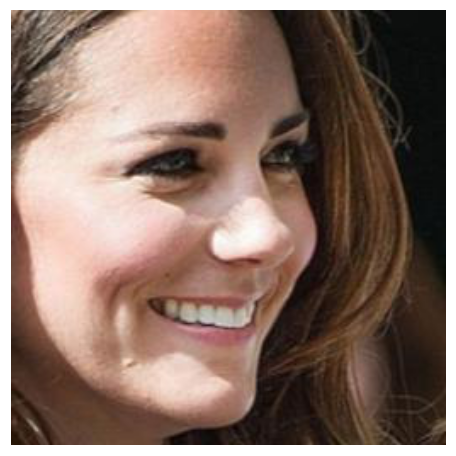

In [130]:
Image.init_from_channels_at_back(input_pixels[:,:,:3]).view()
# Image.init_from_channels_at_back(np.mean(lms_hm_prediction[0],axis=-1)).view(alpha=0.75)

In [131]:
# Image.init_from_channels_at_back(lms_hm_prediction[0]).view()

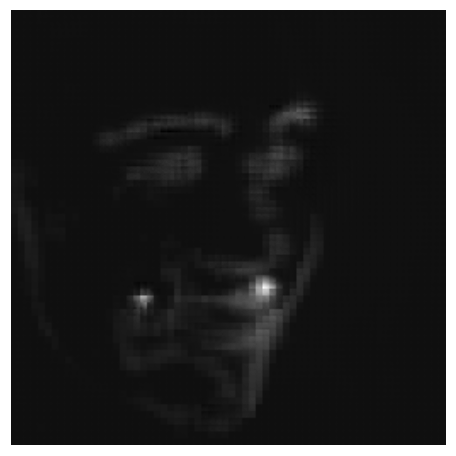

In [132]:
Image.init_from_channels_at_back(np.mean(lms_hm_prediction[0], axis=-1)).view()

In [133]:
hs = np.argmax(np.max(lms_hm_prediction.squeeze().transpose(2,0,1), 2), 1)
ws = np.argmax(np.max(lms_hm_prediction.squeeze().transpose(2,0,1), 1), 1)
pts_predictions = np.stack([hs,ws]).T

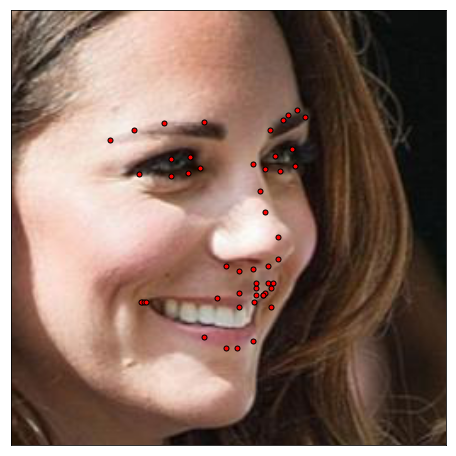

In [134]:
Image.init_from_channels_at_back(input_pixels[:,:,:3]).view()
PointCloud(pts_predictions[17:]).view()